In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import math
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
import warnings

warnings.filterwarnings(action='ignore') 

In [30]:
from tqdm import tqdm 
import pandas as pd 
import numpy as np
from collections import defaultdict

def calc_fft(input_filename):
    fft_list = []
    chunksize = 10544
    df = pd.read_csv(input_filename, chunksize = chunksize,index_col=0)
    for i,df_chunk in tqdm(enumerate(df)):
        if len(df_chunk) != chunksize : break
        fft_c1 = np.fft.fft(df_chunk.iloc[:,0])[:chunksize//2]/chunksize * 2
        fft_c2 = np.fft.fft(df_chunk.iloc[:,1])[:chunksize//2]/chunksize * 2
        fft_list.append(np.abs(np.hstack([fft_c1,fft_c2])))
        assert len(fft_list[-1])==chunksize
    return fft_list

def get_fft_dict(phmap_train):
    fft_dict = defaultdict(list)
    for name in phmap_train:
        file_path = f'./phmap_train/train_{name}.csv'
        label = name.split('_')[-1]
        print(label)
        fft_dict[label] += calc_fft(file_path)
    for key in fft_dict:
        fft_dict[key] = np.array(fft_dict[key])
    return fft_dict
    
def select_index(raw_data_dict,q):
    selected_index = []
    for label in raw_data_dict:
        raw_data = raw_data_dict[label]
        N = len(raw_data[0])
        sum_fft_c1 = np.sum(raw_data[:,:N//2],axis=0)
        sum_fft_c2 = np.sum(raw_data[:,N//2:],axis=0)
        th_c1 = np.quantile(sum_fft_c1,q)
        th_c2 = np.quantile(sum_fft_c2,q)
        selected_index += list(np.where(sum_fft_c1>th_c1)[0])
        selected_index += list(np.where(sum_fft_c2>th_c2)[0]+N//2)
    selected_index = sorted(list(set(selected_index)))
    return selected_index

def get_selected_data(raw_data_dict,selected_index):
    selected_data = []
    label_list = []
    for label in raw_data_dict:
        raw_data = raw_data_dict[label][:,selected_index]
        selected_data.append(raw_data)
        label_list += [label]*len(raw_data)
    selected_data = np.vstack(selected_data)
    return selected_data,label_list        

In [31]:
# from sklearn.model_selection import train_test_split
# train_data = get_fft_dict(['1st_Normal', '1st_Bearing', '1st_Unbalance', '1st_Looseness', '1st_high',
#                            '2nd_Bearing', '2nd_Looseness', '2nd_Unbalance', '3rd_Normal', '3rd_Unbalance'])
# selected_index = select_index(train_data,0.5)
# selected_data,label_list = get_selected_data(train_data,selected_index)
# X = selected_data
# y = label_list
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [32]:
day1_data = get_fft_dict(['1st_Normal', '1st_Bearing', '1st_Unbalance', '1st_Looseness', '1st_high'])
day23_data = get_fft_dict(['2nd_Bearing', '2nd_Looseness', '2nd_Unbalance', '3rd_Normal', '3rd_Unbalance'])
selected_index = select_index(day1_data,0.0)
selected_data,label_list = get_selected_data(day1_data,selected_index)
selected_data_23,label_list_23 = get_selected_data(day23_data,selected_index)

Normal


1485it [00:07, 209.16it/s]


Bearing


1800it [00:08, 207.43it/s]


Unbalance


1117it [00:05, 205.33it/s]


Looseness


609it [00:02, 204.37it/s]


high


415it [00:02, 203.40it/s]


Bearing


3890it [00:18, 208.14it/s]


Looseness


3069it [00:15, 204.58it/s]


Unbalance


2853it [00:14, 201.37it/s]


Normal


5017it [00:25, 200.14it/s]


Unbalance


2239it [00:11, 202.78it/s]


In [6]:
x_train = selected_data
y_train = label_list
x_test = selected_data_23
y_test = label_list_23

In [7]:
# random_state는 시드값을 고정해줌
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(x_train, y_train)
model_pred = model.predict(x_test)

Accuracy: 0.6042887274431685
F1-Score: 0.6043
              precision    recall  f1-score   support

     Bearing       0.00      0.00      0.00      3890
   Looseness       0.81      0.14      0.24      3069
      Normal       0.45      0.95      0.61      5017
   Unbalance       1.00      1.00      1.00      5092
        high       0.00      0.00      0.00         0

    accuracy                           0.60     17068
   macro avg       0.45      0.42      0.37     17068
weighted avg       0.58      0.60      0.52     17068



<Axes: >

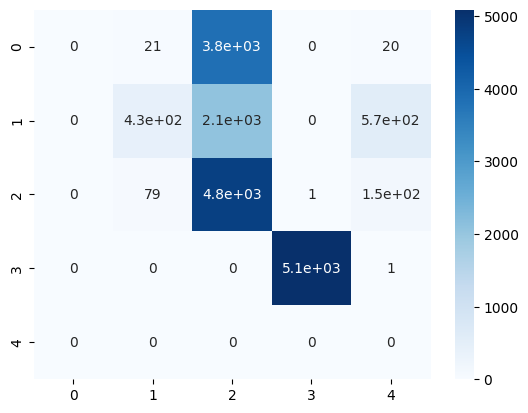

In [8]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
accuracy = model.score(x_test, y_test)
print("Accuracy:", accuracy)
# f1-score에서 average가 binary로 디폴트 설정 되어 있는데 이것은 이진분류에 적합하여 micro로 바꿔 다중 클래스 분류를 해줌
f1 = f1_score(y_test, model_pred, average='micro')
print("F1-Score: {:.4f}".format(f1))
print(classification_report(y_test, model_pred))
cm = pd.DataFrame(confusion_matrix(y_test, model_pred))
sns.heatmap(cm, annot=True, cmap='Blues')

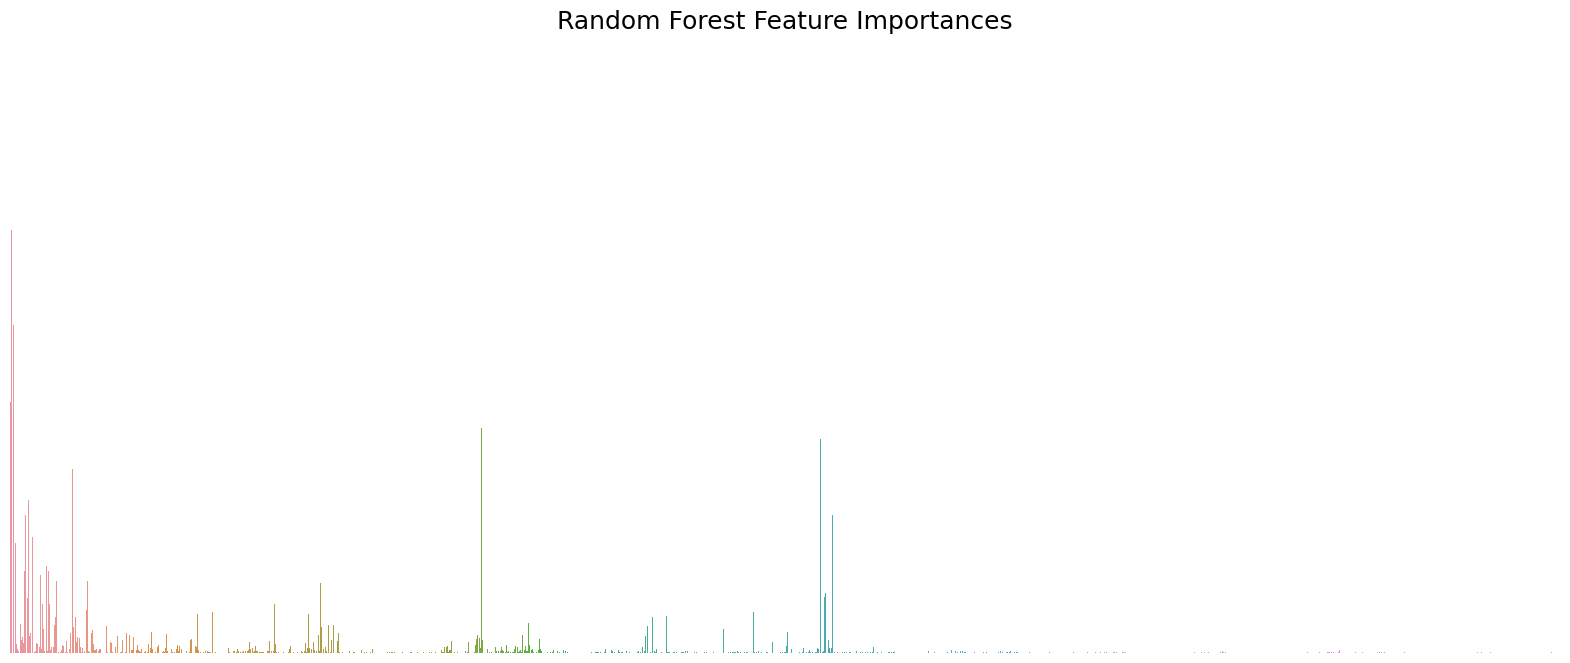

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances 평가

# 어레이 형태 다시 데이터 프레임으로 전환
x_train_df = pd.DataFrame(x_train)

importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': x_train_df.columns, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# 특성 중요도 시각화 -> Feature들이 왜 그런진 모르겠지만 오름차순 정렬이 안됨
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data = importance_df)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.axis('off')
plt.show()

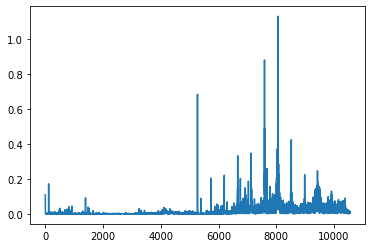

In [64]:
plt.plot(day1_data['Normal'][0])

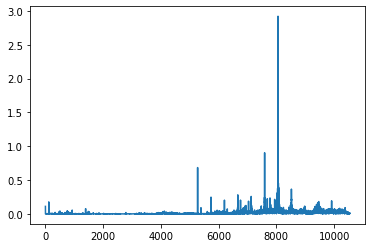

In [65]:
plt.plot(day1_data['Normal'][1])

In [67]:
pd.DataFrame(day1_data['Normal']).describe()

,0,1,2,3,4,5,6,7,8,9,...,10534,10535,10536,10537,10538,10539,10540,10541,10542,10543
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,...,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,0.105413,0.000977,0.000584,0.000485,0.000445,0.000470,0.000442,0.000677,0.000474,0.000406,...,0.013143,0.013237,0.013017,0.012686,0.013212,0.013212,0.013896,0.013924,0.014827,0.014777
std,0.013447,0.000784,0.000399,0.000301,0.000270,0.000277,0.000257,0.000395,0.000266,0.000222,...,0.008242,0.008523,0.008250,0.008095,0.008401,0.008545,0.009265,0.009247,0.010153,0.010333
min,0.084115,0.000011,0.000020,0.000012,0.000012,0.000021,0.000005,0.000017,0.000006,0.000012,...,0.000244,0.000473,0.000144,0.000459,0.000096,0.000283,0.000516,0.000107,0.000168,0.000228
25%,0.096204,0.000331,0.000270,0.000245,0.000238,0.000261,0.000251,0.000397,0.000281,0.000239,...,0.006896,0.006614,0.006922,0.006380,0.006587,0.006681,0.006753,0.006800,0.007274,0.006836
50%,0.101023,0.000628,0.000471,0.000435,0.000403,0.000432,0.000400,0.000621,0.000431,0.000384,...,0.011570,0.011506,0.011445,0.010922,0.011311,0.011524,0.012086,0.011908,0.012604,0.012086
75%,0.109505,0.001686,0.000873,0.000680,0.000615,0.000623,0.000591,0.000886,0.000616,0.000539,...,0.017640,0.018273,0.017525,0.017224,0.018403,0.018180,0.019027,0.018967,0.020332,0.020070
max,0.145781,0.004755,0.002344,0.001696,0.002257,0.001796,0.001905,0.003250,0.002071,0.001762,...,0.048680,0.051628,0.046071,0.056907,0.045973,0.051274,0.053391,0.053329,0.062616,0.059573


In [ ]:
N1_df = pd.DataFrame(day1_data['Normal'])
N3_df = pd.DataFrame(day23_data['Normal'])

fig, ax = plt.subplots(2110, 5, figsize=(10, 20))

for i in range(len(N1_df.columns)):
    if i%5==0:
        row = i // 5
        col = i % 5
        ax[row, col].boxplot([N1_df.iloc[:, i], N3_df.iloc[:, i]])
        ax[row, col].set_xlabel('Data Type')
        ax[row, col].set_ylabel('Value')
        
plt.show()